In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn

import imp
import time
import utils.movie_readin as mru
import utils.plotutils as plu

In [ ]:
imp.reload(mru)
#movie parameters
movie = 'full_ocean'
#movie = 'ocean_control'
#movie = 'ocean_overlay'
#movie = 'willows_control'

if(movie == 'full_ocean'):
    movie_dirpath = '/home/vasha/research/datasets/stationary_motion/pixel2xlmomentlens/full_framerate/'
    movie_name = 'ocean_only_120.mp4_120fps.mp4'

#if(movie == 'full_reeds'):
#    movie_dirpath = '/home/vasha/research/datasets/stationary_motion/pixel2xlmomentlens/full_framerate/'
#    movie_name = 'ocean_only_120.mp4_120fps.mp4' 
    
elif(movie =='ocean_control'):
    movie_dirpath = '/home/vasha/research/datasets/eyetrace_overlay/'
    movie_name = 'ocean_movie_control_overlay.mp4'

elif(movie =='ocean_overlay'):
    movie_dirpath = '/home/vasha/research/datasets/eyetrace_overlay/'
    movie_name = 'ocean_movie_trace_overlay.mp4'

elif(movie =='willows_control'):
    movie_dirpath = '/home/vasha/research/datasets/eyetrace_overlay/'
    movie_name = 'willows_movie_control_overlay.mp4'   
    

movie_filepath = movie_dirpath + movie_name
pixel_patchsize = 16
frame_patchsize = 1024
maxframes = 1024
savefolder = './output/wdecay_'
# read in the movie
#willows = mru.get_movie(movie_filepath, pixel_patchsize, frame_patchsize,
#                          normalize_patch=False, normalize_movie=True, encoding='mp4')
# plot a test movie
#test = willows[10,0,:,:]
#plt.imshow(test)

# hyperparameters
num_epochs = 1000
batch_sizes = [100, 500, 1000]
learning_rates = [1e-3, 1e-4]
learning_momentum = 1
#N_TEST_IMG = 5
lambda_activation = 0
lambda_biophysical = 0

# model parameters
conv_width = 5
hidden_nodes = 256
compression = pixel_patchsize**2 / hidden_nodes
#compression = 6
#hidden_nodes = pixel_patchsize**2 // compression
print(f'Model:{pixel_patchsize}^2 pixels by {frame_patchsize} frames, to {hidden_nodes} hidden nodes for {compression}x compression')


# make it a Pytorch dataset (inherits from Dataset)
class NaturalMovieDataset(Dataset):
    """Dataset of Stationary Naural Movies"""
    
    def __init__(self, movie_filepath, pixel_patchsize, frame_patchsize,
                     normalize_patch=True, normalize_movie=False, encoding='mp4'):
        """
        Args:
            movie_filepath (string): Path to the movie file
            pixel_patchsize (int): Number of pixels on the edge of a patch
            frame_patchsize (int): Number of frames in the movie
        """
        self.movies = mru.get_movie(movie_filepath, pixel_patchsize, maxframes, frame_patchsize,
                          normalize_patch=normalize_patch, normalize_movie=normalize_movie, encoding='mp4',
                          crop=False)

    def __len__(self):
        return len(self.movies)

    def __getitem__(self, idx):
        movie = self.movies[idx,:,:,:]
        movie = torch.from_numpy(movie)
        sample = Variable(movie)
        return sample

try:
    movie_dataset
except NameError:    
    movie_dataset = NaturalMovieDataset(movie_filepath, pixel_patchsize, frame_patchsize,
                              normalize_patch=False, normalize_movie=False, encoding='mp4')

print(f'Dataset Ready. {len(movie_dataset)} movie patches each of  {frame_patchsize}^2 pixel frames')


Training model:16^2 pixels by 1024 frames, to 256 hidden nodes for 1.0x compression
(1026, 1080, 1920, 3)
making patches...
(8040, 16, 16, 1024)
Dataset Ready. 8040 movie patches each of  1024^2 pixel frames


In [ ]:
class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        
        temporal_conv_kernel_size = (conv_width, pixel_patchsize, pixel_patchsize)

        self.tconv = nn.utils.weight_norm(nn.Conv3d(1,
                                                   hidden_nodes, 
                                                   kernel_size=temporal_conv_kernel_size,
                                                   stride=1),
                                        name='weight', dim=-1)
        
        #self.tconv = nn.Conv3d(1,
        #                       hidden_nodes, 
        #                       kernel_size=temporal_conv_kernel_size,
        #                       stride=1)
            
        self.tdeconv = nn.ConvTranspose3d(hidden_nodes,
                                          1,
                                          kernel_size = np.transpose(temporal_conv_kernel_size),
                                          stride=1)
        
    def tdeconv_tied(self, acts):
        out = F.conv_transpose3d(acts,
                                self.tconv.weight) #tied weights
        return(out)

    def encode(self, x):
        noise = 0
        x = x + noise
        activations = F.relu(self.tconv(x))
        return activations

    def decode(self, z):
        # recon = self.ttonv(z) # non tied weights
        recon = self.tdeconv_tied(z)
        return recon

    def forward(self, x):
        activations = self.encode(x)
        #z = self.reparametrize(mu, logvar)
        decoded = self.decode(activations)
        return activations, decoded
    
#scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

def loss_func(x, xhat, activations):
        recon_loss = ((x-xhat)**2).mean()
        activation_loss = torch.abs(activations).mean() * lambda_activation
        loss = recon_loss + activation_loss
        return(loss)
    
for batch_size in batch_sizes:
    
    train_loader = DataLoader(movie_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=8)
    
    for learning_rate in learning_rates:
        
        
        print(f'Learning Rate:{learning_rate}; batch size:{batch_size}')
        # our model
        model = AEC()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            model.cuda()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.5)#, momentum=learning_momentum)

        print_epocs = 10
        printing_modulo = num_epochs/print_epocs
        loss_history = []
        print(f'Training {num_epochs} Epochs. ',end="")

        for i in range(num_epochs):
            start = time.time()
            times = []
            for movie in train_loader:
                movie = torch.unsqueeze(movie,1)
                movie = Variable(movie.float()).cuda()
                optimizer.zero_grad()
                acts = model.encode(movie)
                recon = model.decode(acts)
                loss = loss_func(movie, recon, acts)
                loss_history.append(loss.detach())
                loss.backward()
                optimizer.step()
                end = time.time()
                times.append(end-start)
            if(True):
                if(i==1):
                    print(f'Estimated run time: {round(times[-1]*num_epochs/60,1)}mins.')
                elif((i+1)%printing_modulo==0):
                    print(f'Epoch {i+1}/{num_epochs} (mean time per epoch: {round(np.mean(times),1)}s)')
                else:
                    print('*',end='')

        params = f'lr{learning_rate}_bs{batch_size}'

        loss_evolution = [np.float(loss.detach()) for loss in loss_history]
        p = plt.plot(loss_evolution)
        plt.savefig(f'{savefolder}loss_{params}.png')
        plt.clf()
        p = plt.plot(np.log(loss_evolution))
        plt.savefig(f'{savefolder}logloss_{params}.png')
        plt.clf()

        mp = model.parameters()
        bias = np.array(next(mp).detach())
        wnorm = next(mp)
        inw = np.array(next(mp).squeeze().detach())
        outw = np.array(next(mp).squeeze().detach())

        p = plu.plot_temporal_weights(inw)
        plt.savefig(f'{savefolder}inw_{params}.png')
        plt.clf()
        p = plu.plot_temporal_weights(outw)
        plt.savefig(f'{savefolder}outw_{params}.png')
        plt.clf()


        print('Done!')


Learning Rate:0.001; batch size:100
Training 1000 Epochs. *Estimated run time: 148.7mins.
**************************************************************************************************Epoch 100/1000 (mean time per epoch: 5.0s)
***************************************************************************************************Epoch 200/1000 (mean time per epoch: 4.9s)
***************************************************************************************************Epoch 300/1000 (mean time per epoch: 4.9s)
***************************************************************************************************Epoch 400/1000 (mean time per epoch: 5.0s)
***************************************************************************************************Epoch 500/1000 (mean time per epoch: 5.0s)
***************************************************************************************************Epoch 600/1000 (mean time per epoch: 5.1s)
***********************************************************

In [ ]:
if(False):
    moreepochs = 2000
    print(f'Training for {moreepochs} more Epochs:')
    for i in range(moreepochs):
        start = time.time()
        times = []
        for movie in train_loader:
            movie = torch.unsqueeze(movie,1)
            #print(movie.size())
            movie = Variable(movie.float()).cuda()
            optimizer.zero_grad()
            acts = model.encode(movie)
            recon = model.decode(acts)
            loss = loss_func(movie, recon, acts)
            loss_history.append(loss.detach())
            loss.backward()
            optimizer.step()
            end=time.time()
            times.append(end-start)
            
        if((i+1)%printing_modulo==0):
            print(f'{i+1}th Epoch (mean time per epoch: {round(np.mean(times))}s)')
        else:
            print('*',end='')

    print('Done!')

In [ ]:
loss_evolution = [np.float(loss.detach()) for loss in loss_history]
plt.plot(loss_evolution)
plt.show()
plt.plot(np.log(loss_evolution))

(256, 5, 16, 16)
(256,)
(256, 5, 16, 16)


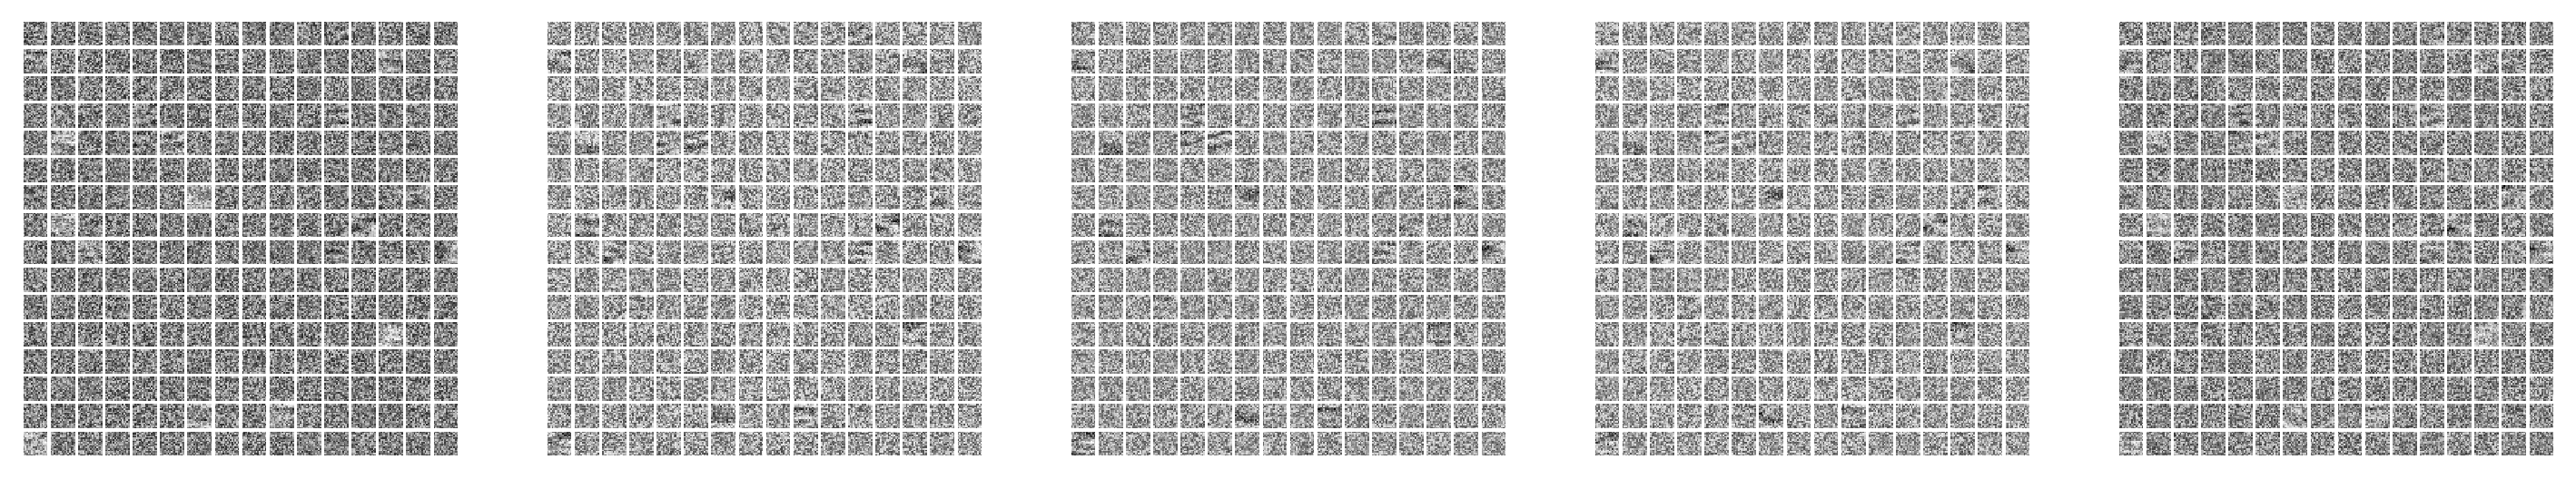

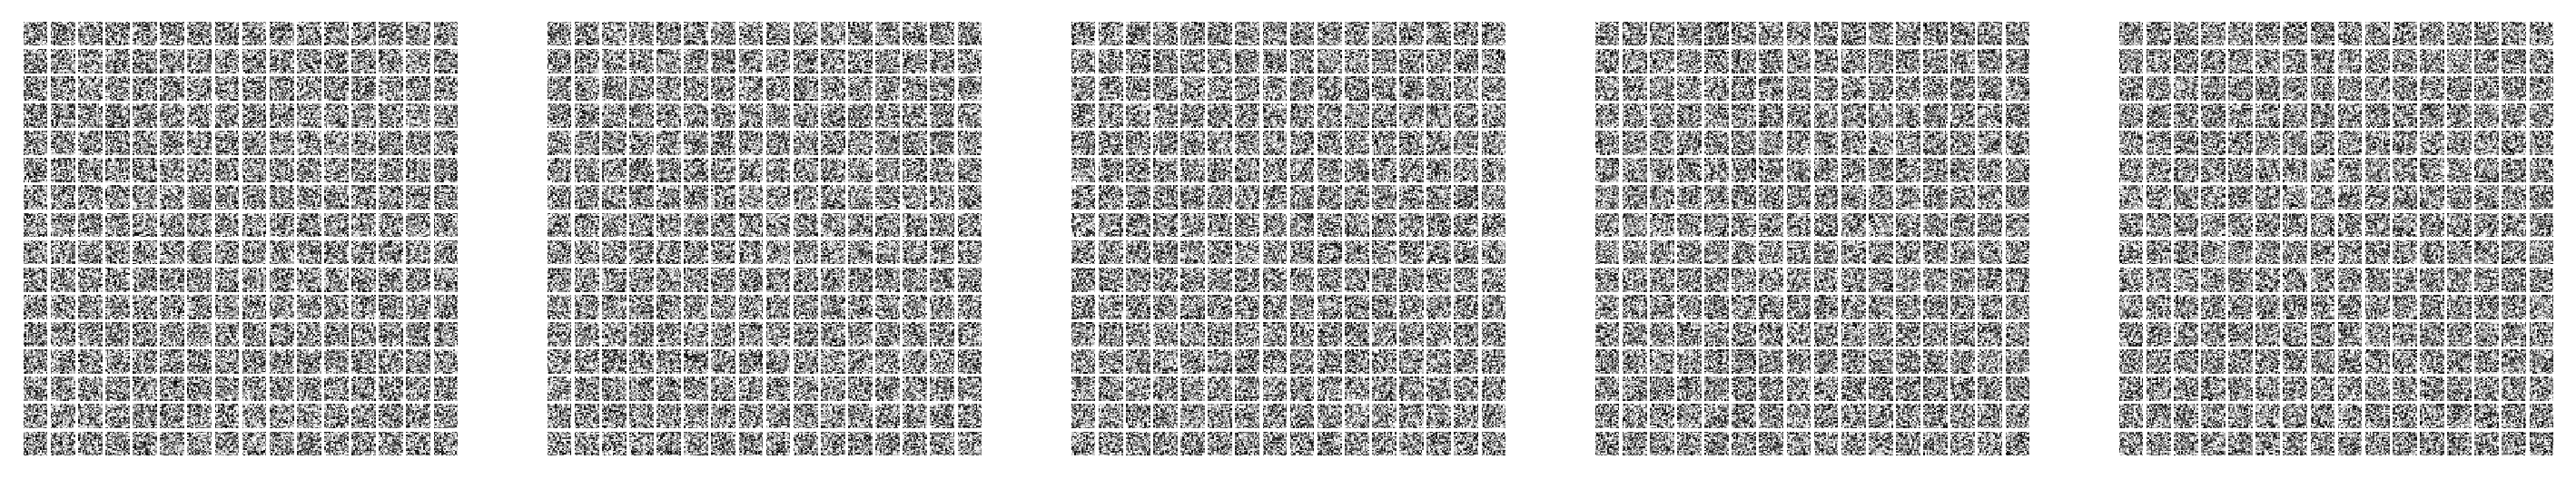

In [7]:
imp.reload(plu)
mp = model.parameters()
bias = np.array(next(mp).detach())
wnorm = next(mp)
inw = np.array(next(mp).squeeze().detach())
outw = np.array(next(mp).squeeze().detach())

print(inw.shape)
print(bias.shape)
print(outw.shape)
p = plu.plot_temporal_weights(inw)
p = plu.plot_temporal_weights(outw)

(256, 5, 16, 16)
0.054768417
-0.051098738


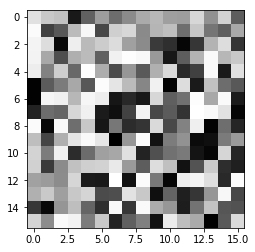

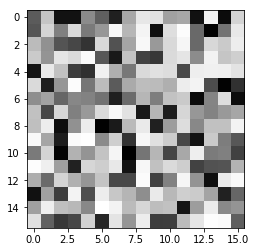

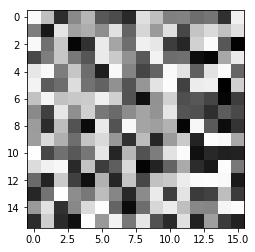

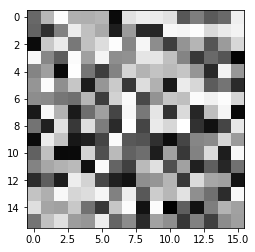

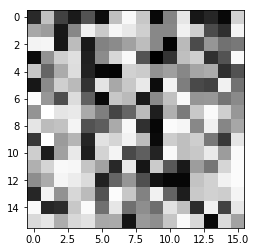

In [13]:
print(inw.shape)
print(np.max(inw))
print(np.min(inw))
for i in range(inw.shape[1]):
    plt.imshow(inw[18,i,:,:],cmap='Greys_r')
    plt.show()

torch.Size([100, 1, 1024, 16, 16])
tensor([[226., 226., 227., 228., 226., 226., 224., 220., 214., 213., 214., 215.,
         219., 220., 221., 221.],
        [229., 230., 230., 230., 228., 226., 224., 221., 219., 218., 215., 215.,
         215., 216., 219., 220.],
        [231., 232., 231., 229., 228., 225., 223., 220., 222., 218., 215., 214.,
         211., 209., 204., 200.],
        [231., 231., 230., 228., 225., 223., 220., 218., 217., 216., 215., 211.,
         200., 194., 189., 190.],
        [230., 230., 228., 225., 224., 223., 222., 222., 212., 206., 197., 193.,
         189., 188., 183., 178.],
        [226., 226., 226., 225., 223., 223., 223., 223., 207., 208., 207., 204.,
         198., 197., 197., 197.],
        [224., 224., 224., 224., 223., 224., 223., 223., 224., 224., 224., 226.,
         226., 225., 221., 220.],
        [223., 223., 223., 223., 224., 225., 224., 224., 223., 222., 221., 219.,
         216., 215., 215., 215.],
        [219., 221., 223., 223., 224., 224., 

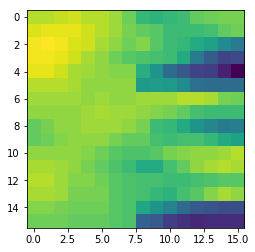

In [9]:
print(movie.shape)
m = movie[7,0,1,:,:]
plt.imshow(m)
print(m)

Movies:


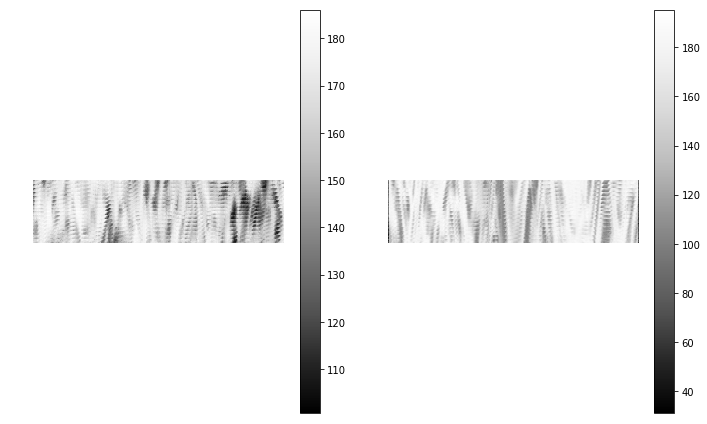

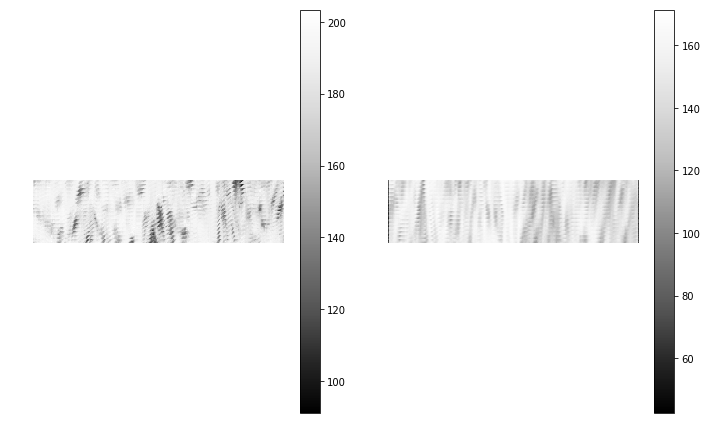

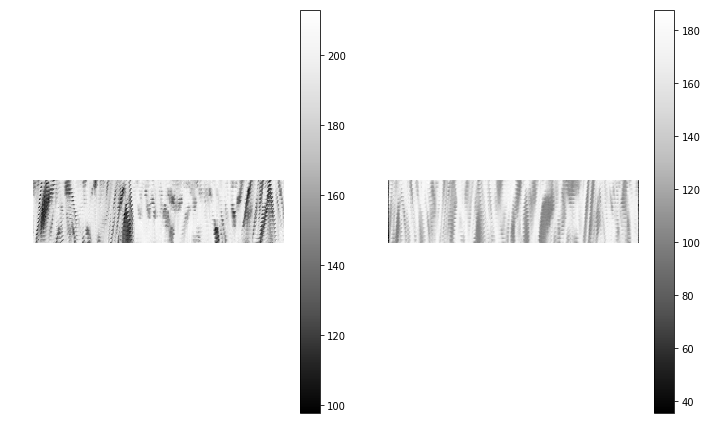

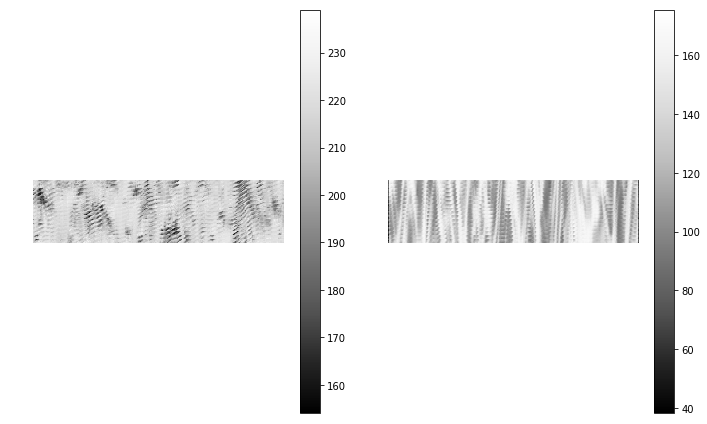

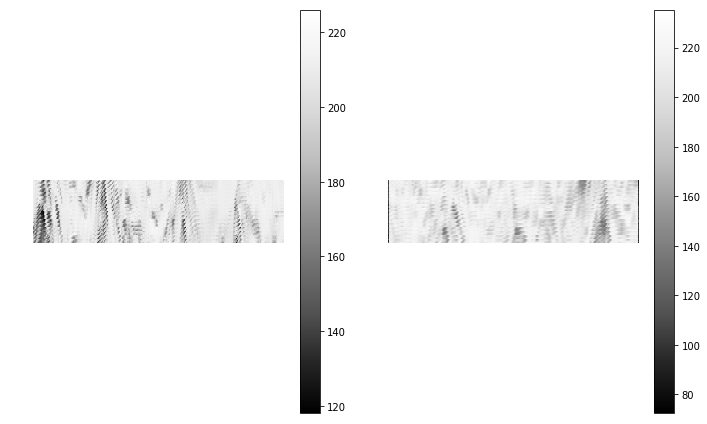

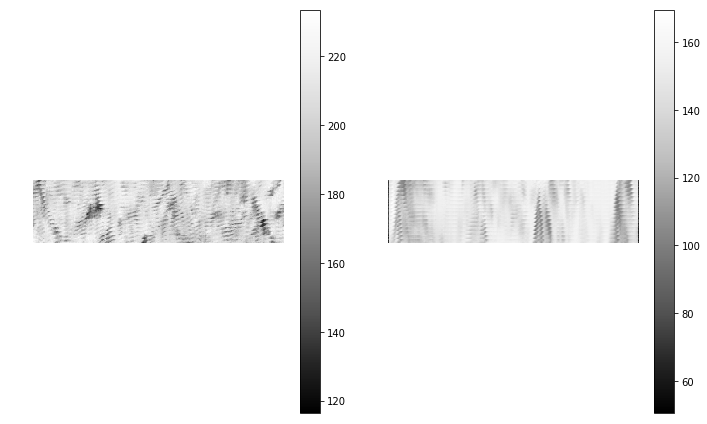

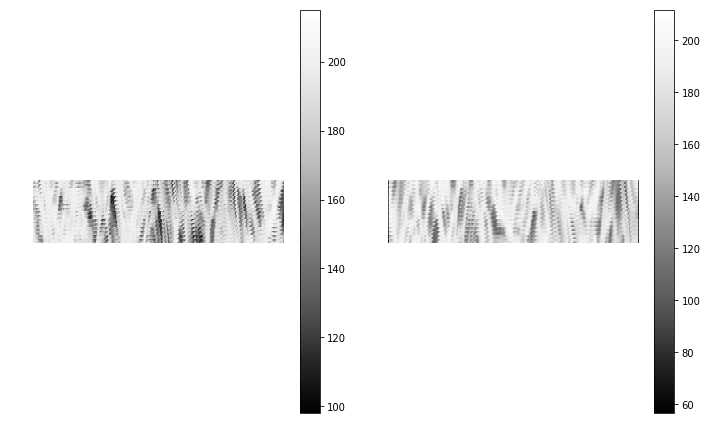

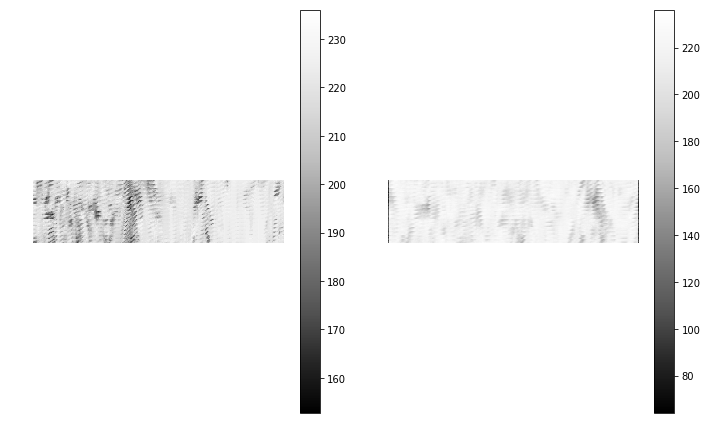

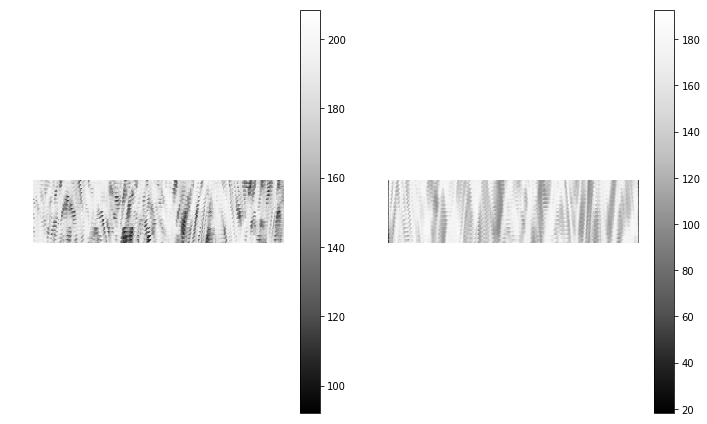

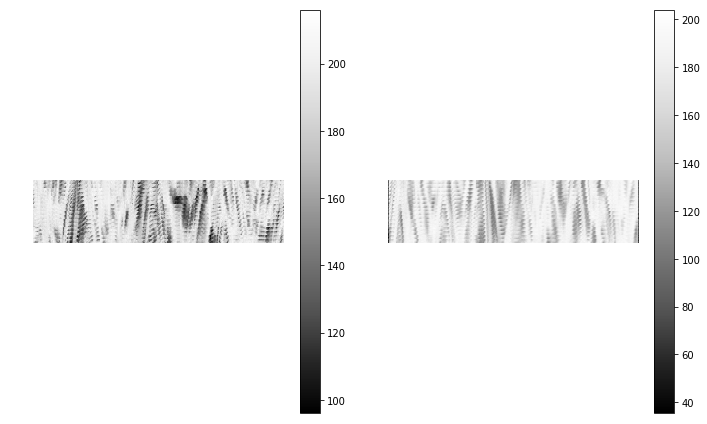

In [10]:
imp.reload(plu)
print('Movies:')
for i in range(10):
    plu.plot_movies_recons(np.squeeze(movie), np.squeeze(recon), i)
    #plt.colorbar()
plt.show()


In [ ]:
def visualize_aec():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(train_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.encode(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Recon Images')


visualize_aec()
plt.ioff()
plt.show()

In [ ]:
torchvision.utils.make_grid(input_tensor)

In [ ]:
# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

    
    
for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
    

In [ ]:
model = AEC()
if torch.cuda.is_available():
    model.cuda()